<a href="https://colab.research.google.com/github/vdragon95/lol_project/blob/develop/LOL06_win_rate_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pwd

'/content'

In [ ]:
# 해야 할 일
'''
[멀티 서치 매칭 승률 분석을 위한 학습 모델 구축]
    소환사이름을 입력하면....

    1. 각 소환사가 속했던 팀 데이터의 평균 (from 05teams_diff_data.csv) → 두 팀간 차이를 이용하여 머신 러닝 할 것
    
    2. 조합 승률 데이터 (from 07indi_exclusive_matches_df.csv) → 최종 보여줄 자료 → 소환사 10명의 데이터를 이용하여 머신러닝할것
     각 소환사의 한 게임 내 개인 평균 데이터 (from 08summoner_final_for_analysis.csv) 

+ 소환사별 챔피언 MOST 픽 및 승률, KDA 데이터 처리
+ 각 모델 별 predict 해서 실제값 구할 수 있게 처리 (accuracy_score, out-of-bag score 차이점?)
'''

'\n[멀티 서치 매칭 승률 분석을 위한 학습 모델 구축]\n    소환사이름을 입력하면....\n\n    1. 각 소환사가 속했던 팀 데이터의 평균 (from 05teams_diff_data.csv) → 두 팀간 차이를 이용하여 머신 러닝 할 것\n    \n    2. 조합 승률 데이터 (from 07indi_exclusive_matches_df.csv) → 최종 보여줄 자료 → 소환사 10명의 데이터를 이용하여 머신러닝할것\n     각 소환사의 한 게임 내 개인 평균 데이터 (from 08summoner_final_for_analysis.csv) \n\n+ 소환사별 챔피언 MOST 픽 및 승률, KDA 데이터 처리\n+ 각 모델 별 predict 해서 실제값 구할 수 있게 처리 (accuracy_score, out-of-bag score 차이점?)\n'

In [ ]:
import requests
import pandas as pd
import numpy as np
import time

'''☆통합된 버전'''
# match_info_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/all/02all_match_info_queue_revised_data.csv', encoding = 'cp949')

'☆통합된 버전'

In [ ]:
# 1. 팀 데이터 정보로 승률 예측
#   [소환사별 팀 평균 데이터] (02match_info_queue_revised_data & 03team_data_merged)

match_info_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/all/02all_match_info_queue_revised_data.csv', encoding = 'cp949')
team_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/all/03team_data_merged.csv', encoding = 'cp949')
indis_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/all/04indi_data_merged.csv', encoding = 'cp949')


match_info_df = match_info_df[['summonerName', 'gameId', 'champion']]
indi_df = indis_df[['matchId', 'teamId', 'championId']]
indi_df.columns = ['gameId', 'teamId', 'champion']

print(match_info_df)
print(team_df)
print(indi_df)

      summonerName      gameId  champion
0            16xyz  4766618573        68
1            16xyz  4766647089       126
2            16xyz  4766596747       126
3            16xyz  4764301757       126
4            16xyz  4764206762       126
...            ...         ...       ...
76622          버 돌  4636385692        84
76623          버 돌  4636358862        21
76624          버 돌  4632748326       236
76625          버 돌  4632665472       126
76626          버 돌  4629956187       120

[76627 rows x 3 columns]
             gameId  teamId  win  ...  towerKills  inhibitorKills  baronKills
0      4.766619e+09   100.0    0  ...         7.0             0.0         1.0
1      4.766647e+09   100.0    1  ...         6.0             1.0         1.0
2      4.766597e+09   100.0    1  ...         9.0             1.0         0.0
3      4.764302e+09   100.0    0  ...         2.0             0.0         0.0
4      4.764207e+09   100.0    0  ...         2.0             0.0         1.0
...           

In [ ]:
# 중복된 데이터 제거

match_info_df = match_info_df.drop_duplicates()
indi_df = indi_df.drop_duplicates()
team_df = team_df.drop_duplicates()

In [ ]:
#   [summonerName, gameId, win ~ baronKills] 평균 데이터 매핑
# print(len(match_info_df))

# summoner_df = pd.merge(match_info_df, indi_df) → 이 코드를 두줄로 풀어쓰면...
summoner_df = pd.merge(match_info_df, indi_df, how='left')
summoner_df = summoner_df.dropna(axis=0)
# print(len(summoner_team_df))

summoner_team_df = pd.merge(summoner_df, team_df, on=['gameId', 'teamId'])
# print(len(summoner_team_df))
summoner_team_df = summoner_team_df.drop_duplicates(['summonerName', 'gameId', 'teamId'])
# ☆ 어떻게 ['summonerName', 'gameId', 'teamId']이 같은 게임이 여러개 존재하지?, 심지어 summonerName만 다른 경우도 있음 (고유 번호 아니였나?)
# print(len(summoner_team_df))

# pd.set_option('display.max_columns', 500) # 펼쳐 보기 
# print(summoner_team_df)
summoner_col = list(summoner_team_df.columns)
summoner_col.remove('gameId')
summoner_col.remove('champion')
summoner_col.remove('teamId')

summoner_team_mean = summoner_team_df.loc[:, summoner_col].groupby('summonerName', as_index=False).mean()
print(summoner_team_mean)

summoner_team_mean.to_csv('/content/drive/MyDrive/Colab Notebooks/all/10summoner_team_mean_data.csv',index=False,encoding = 'cp949')
print('team merged data file saved!')

    summonerName       win  firstBlood  ...  towerKills  inhibitorKills  baronKills
0       DWG jool  0.422222    0.600000  ...    4.066667        0.466667    0.333333
1      Gen G Bdd  0.484848    0.484848  ...    3.909091        0.424242    0.363636
2     SEKAI ICHI  0.684211    0.605263  ...    5.500000        0.789474    0.394737
3         maerd1  0.423077    0.423077  ...    4.115385        0.500000    0.576923
4         다드몬아이다  0.411765    0.529412  ...    4.147059        0.382353    0.558824
..           ...       ...         ...  ...         ...             ...         ...
902        회광반조1  0.625000    0.375000  ...    4.750000        0.625000    0.312500
903      후리지아꽃향기  0.333333    0.333333  ...    4.666667        0.333333    0.666667
904          훙쌍리  0.425000    0.500000  ...    4.550000        0.525000    0.325000
905          흐 림  0.500000    0.000000  ...    5.333333        0.500000    0.500000
906      힘내다잘될거야  0.564103    0.564103  ...    5.000000        0.564103    0

       firstBlood  firstTower  ...  inhibitorKills  baronKills
36666          -1          -1  ...              -1           0
22772          -1           1  ...               3           2
9947           -1           1  ...               0          -1
22963          -1           1  ...               2           2
9901           -1           1  ...              -2          -2
...           ...         ...  ...             ...         ...
25397           1           1  ...              -2          -2
13627           1           1  ...               1           0
24517           1           1  ...              -1          -1
31296          -1           1  ...              -3           0
34418           1           1  ...               1           0

[27825 rows x 9 columns]
36666    1
22772    0
9947     1
22963    0
9901     1
        ..
25397    1
13627    0
24517    1
31296    1
34418    0
Name: win, Length: 27825, dtype: int64
Out-of-bag score estimate: 0.977
Mean accuracy score: 0.98

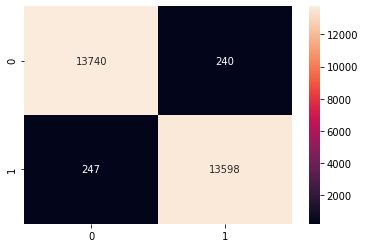

randomforest model for team win rate analysis saved!


In [ ]:
# HTML에서 소환사 이름을 받으면 팀정보를 기반으로 승률을 예측해 줄 모델 구축
#   1. 데이터 전처리 -----------------------------------------
team_diff_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/all/05teams_diff_data.csv', encoding = 'cp949')
# print(team_diff_df)

win_lose = {1 : 0, -1: 1} # win = -1: blue(100) 승, 1: blue(100) 패 (blue팀 기준!) → win = 1:  0: blue(100) 패, blue(100) 승
team_diff_df['win'] = team_diff_df['win'].map(win_lose).tolist()
# print(team_diff_df)

#   2. train / test 분리 -----------------------------------------
from sklearn.model_selection import train_test_split
train, test = train_test_split(team_diff_df.iloc[:, 1:], test_size=0.3, shuffle=True)
# print(train)
# print(test)
x_train = train.iloc[:, 1:]
y_train = train.iloc[:, 0]
x_test = train.iloc[:, 1:]
y_test = train.iloc[:, 0]

x_train_columns = x_train.columns

print(x_train)
print(y_train)
accuracies_team = []

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(x_train, x_test)    # x값만 대상
x_train = sc.transform(x_train)
x_test = sc.transform(x_test)  

#   3. 모델 구축 및 학습, 평가 -----------------------------------------

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, oob_score=True)
rf.fit(x_train, y_train)

from sklearn.metrics import accuracy_score

predicted = rf.predict(x_test)
accuracy = accuracy_score(y_test, predicted)

#oob_score = out of bag score로써 예측이 얼마나 정확한가에 대한 추정치입니다.
print(f'Out-of-bag score estimate: {rf.oob_score_:.3}')
print(f'Mean accuracy score: {accuracy:.3}')

accuracies_team.append({'RandomForest': round(accuracy, 3)})
print(accuracies_team)

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = pd.DataFrame(confusion_matrix(y_test, predicted), columns=[0, 1], index=[0, 1])
sns.heatmap(cm, annot=True, fmt='2g')
plt.show()

#   4. 모델 저장 -----------------------------------------
import pickle

# save the model to disk
pickle.dump(rf, open('/content/drive/MyDrive/Colab Notebooks/all/randomforest_team.sav', 'wb'))
print('randomforest model for team win rate analysis saved!')


In [ ]:
# [tensorflow - deep learning]

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping # 학습시 조기 중단 및 체크 포인트 
import tensorflow as tf

x_train = x_train.astype('float64')
y_train = y_train.astype('float64')
x_test = x_test.astype('float64')
y_test = y_test.astype('float64')
print(x_train.shape)

# 모델 설계
model = Sequential()
model.add(Dense(64, input_dim=len(x_train_columns), activation='relu'))
model.add(tf.keras.layers.BatchNormalization()) # Batch 정규화 - Gradient loss: 등의 문제 해결
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
loss, acc = model.evaluate(x_test, y_test, batch_size=128, verbose=2)

history = model.fit(x_train, y_train, batch_size=128, epochs=40, verbose=2)
acc = history.history['acc']
loss_train, acc_train = model.evaluate(x_train, y_train, batch_size=128, verbose=2)
loss_test, acc_test = model.evaluate(x_test, y_test, batch_size=128, verbose=2)
# print('acc:', acc)
print('acc_train:', acc_train)
print('acc_test:', acc_test)


# print('정확도 :', acc)
accuracies_team.append({'Sequential': round(acc[-1], 3)})
print(accuracies_team)

# 예측 
pred = (model.predict(x_test) > 0.5).astype('int32')
print('예측값:', pred.flatten())
print('실제값:', list(y_test))
print('총 개수: %d, 오류수: %d'%(len(y_test),(y_test != pred.flatten()).sum()))
print(round((y_test == pred.flatten()).sum() / len(y_test) * 100, 2), '%%')

# 모델 저장 시
model.save('/content/drive/MyDrive/Colab Notebooks/all/sequential_team.hdf5')
print('sequential model for team win rate analysis saved!')

(27825, 9)
218/218 - 0s - loss: 0.6800 - acc: 0.6356
Epoch 1/40
218/218 - 1s - loss: 0.1747 - acc: 0.9401
Epoch 2/40
218/218 - 0s - loss: 0.0974 - acc: 0.9649
Epoch 3/40
218/218 - 0s - loss: 0.0935 - acc: 0.9666
Epoch 4/40
218/218 - 0s - loss: 0.0892 - acc: 0.9677
Epoch 5/40
218/218 - 0s - loss: 0.0867 - acc: 0.9671
Epoch 6/40
218/218 - 0s - loss: 0.0838 - acc: 0.9685
Epoch 7/40
218/218 - 0s - loss: 0.0818 - acc: 0.9690
Epoch 8/40
218/218 - 0s - loss: 0.0806 - acc: 0.9688
Epoch 9/40
218/218 - 0s - loss: 0.0765 - acc: 0.9713
Epoch 10/40
218/218 - 0s - loss: 0.0774 - acc: 0.9708
Epoch 11/40
218/218 - 0s - loss: 0.0762 - acc: 0.9719
Epoch 12/40
218/218 - 0s - loss: 0.0766 - acc: 0.9702
Epoch 13/40
218/218 - 0s - loss: 0.0739 - acc: 0.9725
Epoch 14/40
218/218 - 0s - loss: 0.0720 - acc: 0.9723
Epoch 15/40
218/218 - 0s - loss: 0.0722 - acc: 0.9720
Epoch 16/40
218/218 - 0s - loss: 0.0710 - acc: 0.9723
Epoch 17/40
218/218 - 0s - loss: 0.0712 - acc: 0.9734
Epoch 18/40
218/218 - 0s - loss: 0.070

In [ ]:
import pandas as pd
import pickle
from tensorflow.keras.models import load_model

rf = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/all/randomforest_team.sav', 'rb'))
model = load_model('/content/drive/MyDrive/Colab Notebooks/all/sequential_team.hdf5')


import random
summoner_team_mean = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/all/10summoner_team_mean_data.csv', encoding = 'cp949')
ten_summoners_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/all/08summoner_final_for_analysis.csv', encoding = 'cp949')

summoners_name = list(ten_summoners_df['summonerName'])

sample_summoners = random.sample(summoners_name, 10)

blues = random.sample(sample_summoners, 5)
reds = list(set(sample_summoners) - set(blues))

blue_team_summoners = blues
red_team_summoners = reds
print(blue_team_summoners)
print(red_team_summoners)
# blue_team_summoners = ['16xyz', 'HUYATV SPARKLE', '북쪽의 괴물1', '충주갱수', 'daydayup']
# red_team_summoners = ['Shining fans', 'sofm2', 'Liiv Route', 'FA Natalie', '모찌피치모찌피치']

blue_df = pd.DataFrame()
red_df = pd.DataFrame()
for summoners in blue_team_summoners:
    imsi = summoner_team_mean[summoner_team_mean['summonerName'] == summoners]
    blue_df = pd.concat([blue_df, imsi])
for summoners in red_team_summoners:
    imsi = summoner_team_mean[summoner_team_mean['summonerName'] == summoners]
    red_df = pd.concat([red_df, imsi])

blue_df = blue_df.reset_index(drop=True)
red_df = red_df.reset_index(drop=True)

# print(blue_df.iloc[:, 2:])
# print(red_df.iloc[:, 2:])
# print(blue_df.iloc[:, 2:].mean() - red_df.iloc[:, 2:].mean())

both_team_mean_series = blue_df.iloc[:, 2:].mean() - red_df.iloc[:, 2:].mean()
both_team_mean_list = both_team_mean_series.to_list()
print(both_team_mean_series)
print(both_team_mean_list)

both_team_mean_series = both_team_mean_series.to_numpy()[:, np.newaxis]


# 스케일링
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(both_team_mean_series)    # x값만 대상
both_team_mean_series = sc.transform(both_team_mean_series)  
print(both_team_mean_series.shape) # (20, 1) → (1, 20)


both_team_newaxis_mean_series = both_team_mean_series.reshape(1, -1)
print(both_team_newaxis_mean_series.shape)


pred_seq = model.predict([both_team_newaxis_mean_series])
# pred = (model.predict([both_team_mean_list]) > 0.5).astype('int32')
pred_rf = rf.predict([both_team_mean_list])
# pred = (rf.predict([both_team_mean_list]) > 0.5).astype('int32')
print('예측값:', round(pred_seq.flatten()[0], 8)) # blue team (100) 기준
print('예측값:', pred_rf.flatten()[0]) # blue team (100) 기준


['sdasf dfghj', '리그오브래전드ll', 'Joyzzz', 'DYN Blessing', '나는 몽키 D 짱구']
['따 균 좌', '가슴뛰는일', 'EM 상어', 'FA HamBaK', '수고했다 이야공']
firstBlood        -0.051810
firstTower        -0.069726
firstInhibitor     0.007893
firstBaron        -0.015393
firstDragon        0.049925
firstRiftHerald   -0.013762
towerKills        -0.065099
inhibitorKills    -0.030591
baronKills        -0.019992
dtype: float64
[-0.05180952380952386, -0.06972619047619044, 0.007892857142857201, -0.015392857142857097, 0.04992460317460323, -0.013761904761904753, -0.06509920634920618, -0.030591269841269864, -0.019992063492063505]
(9, 1)
(1, 9)
예측값: 0.9999824
예측값: 1


In [ ]:
# 1. 조합 데이터 정보로 승률 예측
#   [소환사별 개인 평균 데이터 → 합산 및 평균] (06indi_ten_data (학습) & 08summoner_final_for_analysis(DB))
ten_indis_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/all/06indi_ten_data.csv', encoding = 'cp949')

ten_indis_df = ten_indis_df.drop_duplicates()

# print(ten_indis_df)
# print(ten_indis_df.columns)
ten_summoners_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/all/08summoner_final_for_analysis.csv', encoding = 'cp949')
# print(ten_summoners_df)
print(len(ten_summoners_df))

col = list(ten_indis_df.columns)
s1 = set(ten_indis_df.columns)
s2 = set(ten_summoners_df.columns)
del_col = list((s1 | s2) - s2) 
for dele in del_col:
    col.remove(dele)
print(col)
print(len(col)) # 21
'''
[features]
sum: ['totalDamageDealt', 'damageDealtToObjectives', 'totalDamageDealtToChampions', 'damageDealtToTurrets',
      'inhibitorKills', 'firstTowerKill', 'turretKills', 'goldEarned', 'goldSpent', 'champLevel', 'totalMinionsKilled',
      'neutralMinionsKilledTeamJungle', 'neutralMinionsKilledEnemyJungle', 'neutralMinionsKilled', 'wardsPlaced', 'wardsKilled']
mean: ['firstBloodKill', 'firstInhibitorKill', 'visionScore', 'kda']

[label]: 'win'
'''
col_sum = col
col_mean = ['firstBloodKill', 'firstInhibitorKill', 'visionScore', 'kda'] # ☆'firstBloodKill', 'firstInhibitorKill'는 평균이 나을까?
for dele in col_mean:
    col_sum.remove(dele)
col_sum.remove('win')
col_label = ['win',]

for target in [col_sum, col_mean, col_label]:
    target.insert(0,'teamId')
    target.insert(0,'matchId')

ten_indis_sum = ten_indis_df[col_sum]
ten_indis_mean = ten_indis_df[col_mean]
ten_indis_label = ten_indis_df[col_label]

ten_indis_sum = ten_indis_sum.groupby(['matchId', 'teamId'], as_index=False).sum()
ten_indis_mean = ten_indis_mean.groupby(['matchId', 'teamId'], as_index=False).mean()
ten_indis_label = ten_indis_label.groupby(['matchId', 'teamId'], as_index=False).max()

ten_fin_df = pd.merge(ten_indis_label, ten_indis_sum)
ten_fin_df = pd.merge(ten_fin_df, ten_indis_mean)
# print(ten_fin_df.iloc[:5, 2:5])
# print(list(ten_fin_df))

ten_fin_df_blue = ten_fin_df.iloc[::2,2:].reset_index(drop=True)
ten_fin_df_red = ten_fin_df.iloc[1::2,3:].reset_index(drop=True)

#### 두 팀간의 차이
#-----------------수정 2020.12.22---------------
ten_fin_df_win = ten_fin_df_blue.iloc[:, 0].copy()
ten_fin_df_blue1 = ten_fin_df_blue.iloc[:, 1:].copy()

ten_fin_df_b_r = ten_fin_df_blue1.subtract(ten_fin_df_red)
ten_fin_df_both = pd.concat([ten_fin_df_win, ten_fin_df_b_r], axis=1)
print(ten_fin_df_both) # [4811 rows x 21 columns]

# win = 1:  0: blue(100) 패, blue(100) 승

# 블루팀 퍼플팀 순서를 바꾸어도 결과는 비슷하게 나오도록 -1 곱한 dataframe 추가

ten_fin_df_b_r2 = ten_fin_df_b_r.multiply(-1)
print(ten_fin_df_b_r2)
# ten_fin_df_both = pd.concat([ten_fin_df_win, ten_fin_df_b_r], axis=1)

win_lose = {0 : 1, 1: 0} # 블루, 퍼플 위치 바꿨으니 승패 결과도 바뀜
ten_fin_df_win2 = ten_fin_df_win.copy()
ten_fin_df_win2 = ten_fin_df_win2.map(win_lose)
print(ten_fin_df_win2)

ten_fin_df_both2 = pd.concat([ten_fin_df_win2, ten_fin_df_b_r2], axis=1)
print(ten_fin_df_both2)

ten_fin_df_both = pd.concat([ten_fin_df_both, ten_fin_df_both2])
print(ten_fin_df_both)

# 두 팀 그냥 나열 (columns 수 비교)
# print(len(ten_fin_df_blue))
# print(len(ten_fin_df_red))
# blue_col = list(ten_fin_df_blue)
# blue_col.extend(list()) 
# ten_fin_df_both = pd.concat([ten_fin_df_blue, ten_fin_df_red], axis=1) # index를 맞춰주고 병합해야 NaN발생 X
# print(c) # [4811 rows x 41 columns]


894
['win', 'totalDamageDealt', 'damageDealtToObjectives', 'totalDamageDealtToChampions', 'damageDealtToTurrets', 'inhibitorKills', 'firstTowerKill', 'turretKills', 'goldEarned', 'goldSpent', 'champLevel', 'totalMinionsKilled', 'firstBloodKill', 'firstInhibitorKill', 'neutralMinionsKilledTeamJungle', 'neutralMinionsKilledEnemyJungle', 'neutralMinionsKilled', 'visionScore', 'wardsPlaced', 'wardsKilled', 'kda']
21
      win  totalDamageDealt  ...  visionScore       kda
0     0.0         -121758.0  ...          0.2 -9.338095
1     0.0          -44704.0  ...         -3.4 -6.650000
2     0.0          -34186.0  ...         -2.2 -6.671667
3     0.0         -111551.0  ...         -3.2 -6.650000
4     1.0           92280.0  ...          8.2  5.762381
...   ...               ...  ...          ...       ...
4806  0.0           23024.0  ...         -4.4 -1.118095
4807  0.0          -86268.0  ...         23.4 -1.773810
4808  0.0           14420.0  ...         -2.6 -5.010455
4809  1.0          10542

Out-of-bag score estimate: 0.994
Mean accuracy score: 1.0
[{'RandomForest': 1.0}]


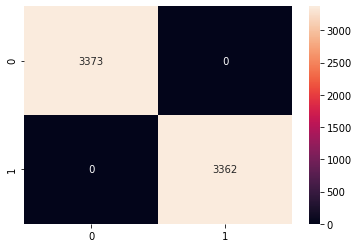

In [ ]:
# HTML에서 소환사 이름을 받으면 조합정보를 기반으로 승률을 예측해 줄 모델 구축
#   1. 데이터 전처리 -----------------------------------------
#       없음

#   2. train / test 분리 -----------------------------------------
from sklearn.model_selection import train_test_split
train, test = train_test_split(ten_fin_df_both, test_size=0.3, shuffle=True)
# print(train)
# print(test)
x_train = train.iloc[:, 1:]
y_train = train.iloc[:, 0]
x_test = train.iloc[:, 1:]
y_test = train.iloc[:, 0]

x_train_columns = x_train.columns
# print(x_train)
# print(y_train)
accuracies_indi = []

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(x_train, x_test)    # x값만 대상
x_train = sc.transform(x_train)
x_test = sc.transform(x_test)  

#   3. 모델 구축 및 학습, 평가 -----------------------------------------

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, oob_score=True)
rf.fit(x_train, y_train)

from sklearn.metrics import accuracy_score

predicted = rf.predict(x_test)
accuracy = accuracy_score(y_test, predicted)

#oob_score = out of bag score로써 예측이 얼마나 정확한가에 대한 추정치입니다.
print(f'Out-of-bag score estimate: {rf.oob_score_:.3}')
print(f'Mean accuracy score: {accuracy:.3}')

accuracies_indi.append({'RandomForest': round(accuracy, 3)})
print(accuracies_indi)

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = pd.DataFrame(confusion_matrix(y_test, predicted), columns=[0, 1], index=[0, 1])
sns.heatmap(cm, annot=True, fmt='2g')
plt.show()


#   4. 모델 저장 -----------------------------------------
import pickle

# save the model to disk
# pickle.dump(rf, open('/content/drive/MyDrive/Colab Notebooks/all/randomforest_indi.sav', 'wb'))
# print('randomforest model for indi win rate analysis saved!')



In [ ]:
# [tensorflow - deep learning]

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping # 학습시 조기 중단 및 체크 포인트 
import tensorflow as tf

x_train = x_train.astype('float64')
y_train = y_train.astype('float64')
x_test = x_test.astype('float64')
y_test = y_test.astype('float64')
print(x_train)
print(x_train.shape)
print(type(x_train))

# 모델 설계
model = Sequential()
model.add(Dense(64, input_dim=len(x_train_columns), activation='relu'))
model.add(tf.keras.layers.BatchNormalization()) # Batch 정규화 - Gradient loss: 등의 문제 해결
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

epochs = 20
history = model.fit(x_train, y_train, batch_size=128, epochs=epochs, verbose=2)
acc = history.history['acc']
# print('정확도 :', acc)
accuracies_indi.append({'Sequential': round(acc[-1], 3)})
print(accuracies_indi)

loss_train, acc_train = model.evaluate(x_train, y_train, batch_size=128, verbose=2)
loss_test, acc_test = model.evaluate(x_test, y_test, batch_size=128, verbose=2)
print('acc:', acc)
print('acc_train:', acc_train)
print('acc_test:', acc_test)

# 예측 
pred = (model.predict(x_test) > 0.5).astype('int32')
print('예측값:', pred.flatten())
print('실제값:', list(y_test))
print('총 개수: %d, 오류수: %d'%(len(y_test),(y_test != pred.flatten()).sum()))
print(round((y_test == pred.flatten()).sum() / len(y_test) * 100, 2), '%%')

# 모델 저장 시
# model.save('/content/drive/MyDrive/Colab Notebooks/all/sequential_indi.hdf5')
# print('sequential model for indi win rate analysis saved!')


[[-9.32881444e-01 -8.90185669e-01 -2.00322721e-01 ... -2.26365696e-03
  -5.60238539e-01 -4.54070880e-01]
 [-8.58975958e-01 -8.10434837e-01 -7.58324081e-01 ... -1.17501209e+00
  -2.34318445e-01 -9.32957848e-01]
 [ 4.90510564e-01  1.40802791e+00  4.90198466e-01 ...  1.17048477e+00
   1.50859848e-01  9.05450151e-01]
 ...
 [ 3.12356879e-01 -6.80130869e-01 -1.21848832e+00 ... -2.26365696e-03
  -1.27133693e+00 -1.39103005e-01]
 [ 1.09755185e+00  7.13746089e-01  6.25411561e-01 ...  1.17048477e+00
   8.32329136e-01  1.20875044e+00]
 [ 6.93625323e-04  4.03300268e-01  2.76330923e-01 ... -1.17501209e+00
   9.16016495e-02 -2.43133756e-01]]
(6735, 20)
<class 'numpy.ndarray'>
Epoch 1/20
53/53 - 1s - loss: 0.3272 - acc: 0.8780
Epoch 2/20
53/53 - 0s - loss: 0.0480 - acc: 0.9835
Epoch 3/20
53/53 - 0s - loss: 0.0229 - acc: 0.9926
Epoch 4/20
53/53 - 0s - loss: 0.0143 - acc: 0.9961
Epoch 5/20
53/53 - 0s - loss: 0.0119 - acc: 0.9955
Epoch 6/20
53/53 - 0s - loss: 0.0127 - acc: 0.9957
Epoch 7/20
53/53 - 0s -

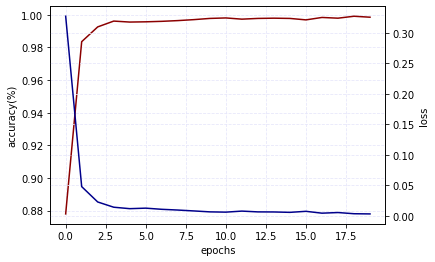

No handles with labels found to put in legend.


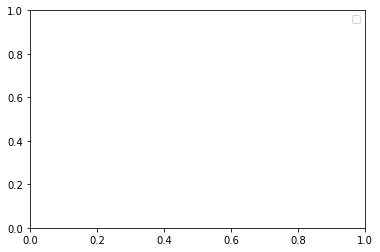

In [ ]:
# 도화지 생성
fig = plt.figure()

# 큰 도화지(fig)를 1x1로 나눈 도화지에 첫 번째 칸에 ax_acc 그래프를 추가한다
ax_acc = fig.add_subplot(111)

# 정확도 그래프 그리기
ax_acc.plot(range(epochs), history.history['acc'], label='accuracy', color='darkred')
# 축 이름
# plt.text(3, 14.7, "accuaracy", verticalalignment='top', horizontalalignment='right')
plt.xlabel('epochs')
plt.ylabel('accuracy(%)')
ax_acc.grid(linestyle='--', color='lavender')

# ax_loos 그래프를 x축을 동일하게 사용하여 겹쳐 그리기 선언
ax_loss = ax_acc.twinx()
ax_loss.plot(range(epochs), history.history['loss'], label='loss', color='darkblue')
# plt.text(3, 2.2, "loss", verticalalignment='top', horizontalalignment='left')
plt.ylabel('loss')
ax_loss.yaxis.tick_right()
ax_loss.grid(linestyle='--', color='lavender')

# 그래프 표시
plt.show()
plt.legend()
plt.savefig('mnist_tensorflow_acc.png')

In [ ]:
import pandas as pd
import pickle
from tensorflow.keras.models import load_model

rf = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/all/randomforest_indi.sav', 'rb'))
model = load_model('/content/drive/MyDrive/Colab Notebooks/all/sequential_indi.hdf5')

import random

ten_summoners_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/all/08summoner_final_for_analysis.csv', encoding = 'cp949')
# print(ten_summoners_df)
summoners_name = list(ten_summoners_df['summonerName'])

random.seed(2)
sample_summoners = random.sample(summoners_name, 10)

blues = random.sample(sample_summoners, 5)
reds = list(set(sample_summoners) - set(blues))

blue_team_summoners = reds
red_team_summoners = blues
print(blue_team_summoners)
print(red_team_summoners)
# red_team_summoners = ['16xyz', 'HUYATV SPARKLE', '북쪽의 괴물1', '충주갱수', 'daydayup']
# blue_team_summoners = ['Shining fans', 'sofm2', 'Liiv Route', 'FA Natalie', '모찌피치모찌피치']
red_team_summoners = ['T1 제우스', 'T1 Cuzz', 'Hide on bush', 'viper3', '곽곽보성']
blue_team_summoners = ['칸 나', 'T1 Oner', 'T1 Fisher', 'T1 Gumayusi', 'T1 Keria']

blue_df = pd.DataFrame()
red_df = pd.DataFrame()
for summoners in blue_team_summoners:
    imsi = ten_summoners_df[ten_summoners_df['summonerName'] == summoners]
    blue_df = pd.concat([blue_df, imsi])
for summoners in red_team_summoners:
    imsi = ten_summoners_df[ten_summoners_df['summonerName'] == summoners]
    red_df = pd.concat([red_df, imsi])

blue_df = blue_df.reset_index(drop=True)
red_df = red_df.reset_index(drop=True)

# print(blue_df.iloc[:, 4:])
# print(red_df.iloc[:, 4:])

print(list(blue_df.iloc[:, 4:].columns))

col_sum = list(blue_df.iloc[:, 4:].columns)
col_mean = ['firstBloodKill', 'firstInhibitorKill', 'visionScore', 'kda'] # ☆'firstBloodKill', 'firstInhibitorKill'는 평균이 나을까?
for dele in col_mean:
    col_sum.remove(dele)

blue_total = blue_df[col_sum].sum().append(blue_df[col_mean].mean()) # .to_numpy() # 수정 2020.12.22 (to_list() → to_numpy())
red_total = red_df[col_sum].sum().append(red_df[col_mean].mean()) # .to_numpy()# 수정 2020.12.22 (to_list() → to_numpy())





#-----------------수정 2020.12.22---------------
both_total = (blue_total - red_total)
print(both_total.shape)
both_total = both_total[:, np.newaxis]
print(both_total.shape) # (20, ) → (20, 1)

# 스케일링
# from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(both_total)    # x값만 대상
both_total = sc.transform(both_total)  
print(both_total.shape) # (20, 1) → (1, 20)


both_newaxis = both_total.reshape(1, -1)
print(both_newaxis.shape)

pred_seq = model.predict([both_newaxis])
# pred = (model.predict([both_total]) > 0.5).astype('int32')
pred_rf = rf.predict(both_newaxis)
# pred = (rf.predict([both_total]) > 0.5).astype('int32')
print('예측값:', pred_seq.flatten()) # blue team (100) 기준
print('예측값:', pred_rf.flatten()) # blue team (100) 기준
print('예측값:', rf.score(both_newaxis, pred_rf.flatten()))

print(0.95438147 + 0.3444934)

['BRB 로머', 'XinMo2', 'HLE 보우거야', '타 잔', '풍월량머독침착맨']
['DRX 게르세르끼', '지도를 보지 않다', 'DWG SojuMaker', '아임쏘쏘리', '혼자 만 의 시간1']
['totalDamageDealt', 'damageDealtToObjectives', 'totalDamageDealtToChampions', 'damageDealtToTurrets', 'inhibitorKills', 'firstTowerKill', 'turretKills', 'goldEarned', 'goldSpent', 'champLevel', 'totalMinionsKilled', 'firstBloodKill', 'firstInhibitorKill', 'neutralMinionsKilledTeamJungle', 'neutralMinionsKilledEnemyJungle', 'neutralMinionsKilled', 'visionScore', 'wardsPlaced', 'wardsKilled', 'kda']
(20,)
(20, 1)
(20, 1)
(1, 20)
예측값: [0.95438147]
예측값: [0.]
예측값: 1.0
1.29887487


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:61: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


In [ ]:
# [괜찮은 조합 찾기]

import itertools

blue_team_summoners = ['16xyz', 'HUYATV SPARKLE', '북쪽의 괴물1', '충주갱수', 'daydayup']
red_team_summoners = ['Shining fans', 'sofm2', 'Liiv Route', 'FA Natalie', '모찌피치모찌피치']
# blue_team_summoners =['kekekekekkkaaa', 'gbzj', 'viper3', '서도일2', '대야웰백']
# red_team_summoners =['DYN Rlch', '스물다섯번째밤', '다시일어낭', '299살까지살게여', 'eren헌터']

all = blue_team_summoners.copy()
all.extend(red_team_summoners)
print(all)

combi = list(itertools.combinations(all, 5))
print(combi)
print(len(combi))

# best_combi = []
best_combi = {}

for com in combi:
    red_team = all.copy()

    blue_team = list(com)
    for dele in blue_team:
        red_team.remove(dele)

    # print(blue_team)
    # print(red_team)

    blue_df = pd.DataFrame()
    red_df = pd.DataFrame()
    for summoners in blue_team:
        imsi = ten_summoners_df[ten_summoners_df['summonerName'] == summoners]
        blue_df = pd.concat([blue_df, imsi])
    for summoners in red_team:
        imsi = ten_summoners_df[ten_summoners_df['summonerName'] == summoners]
        red_df = pd.concat([red_df, imsi])

    blue_df = blue_df.reset_index(drop=True)
    red_df = red_df.reset_index(drop=True)

    col_sum = list(blue_df.iloc[:, 4:].columns)
    col_mean = ['firstBloodKill', 'firstInhibitorKill', 'visionScore', 'kda'] # ☆'firstBloodKill', 'firstInhibitorKill'는 평균이 나을까?
    for dele in col_mean:
        col_sum.remove(dele)

    blue_total = blue_df[col_sum].sum().append(blue_df[col_mean].mean())
    red_total = red_df[col_sum].sum().append(red_df[col_mean].mean())

    both_total = (blue_total - red_total).to_numpy() ## to_numpy() 필요 (Warning 피하기 위함)
    '''FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.'''
    both_total = both_total[:, np.newaxis] # (20, ) → (20, 1)

    # 스케일링
    from sklearn.preprocessing import StandardScaler
    sc = StandardScaler()
    sc.fit(both_total)
    both_total = sc.transform(both_total)  

    both_newaxis = both_total.reshape(1, -1) # (20, 1) → (1, 20)

    pred_seq = model.predict([both_newaxis])
    # print(pred_seq.flatten()[0])

    if pred_seq.flatten()[0] < 0.53 and pred_seq.flatten()[0] > 0.47:
        # best_combi.append({str(blue_team): pred_seq.flatten()[0]})
        best_combi[str(blue_team)] = pred_seq.flatten()[0]

print(best_combi)
print(len(best_combi))


['16xyz', 'HUYATV SPARKLE', '북쪽의 괴물1', '충주갱수', 'daydayup', 'Shining fans', 'sofm2', 'Liiv Route', 'FA Natalie', '모찌피치모찌피치']
[('16xyz', 'HUYATV SPARKLE', '북쪽의 괴물1', '충주갱수', 'daydayup'), ('16xyz', 'HUYATV SPARKLE', '북쪽의 괴물1', '충주갱수', 'Shining fans'), ('16xyz', 'HUYATV SPARKLE', '북쪽의 괴물1', '충주갱수', 'sofm2'), ('16xyz', 'HUYATV SPARKLE', '북쪽의 괴물1', '충주갱수', 'Liiv Route'), ('16xyz', 'HUYATV SPARKLE', '북쪽의 괴물1', '충주갱수', 'FA Natalie'), ('16xyz', 'HUYATV SPARKLE', '북쪽의 괴물1', '충주갱수', '모찌피치모찌피치'), ('16xyz', 'HUYATV SPARKLE', '북쪽의 괴물1', 'daydayup', 'Shining fans'), ('16xyz', 'HUYATV SPARKLE', '북쪽의 괴물1', 'daydayup', 'sofm2'), ('16xyz', 'HUYATV SPARKLE', '북쪽의 괴물1', 'daydayup', 'Liiv Route'), ('16xyz', 'HUYATV SPARKLE', '북쪽의 괴물1', 'daydayup', 'FA Natalie'), ('16xyz', 'HUYATV SPARKLE', '북쪽의 괴물1', 'daydayup', '모찌피치모찌피치'), ('16xyz', 'HUYATV SPARKLE', '북쪽의 괴물1', 'Shining fans', 'sofm2'), ('16xyz', 'HUYATV SPARKLE', '북쪽의 괴물1', 'Shining fans', 'Liiv Route'), ('16xyz', 'HUYATV SPARKLE', '북쪽의 괴물1', 'Shining fa

NameError: ignored

In [ ]:

best_of_value = min(best_combi.values(), key=lambda x: abs(0.5-x))
best_of_key = list(best_combi.keys())[list(best_combi.values()).index(best_of_value)]

best_of_best = {}
best_of_best[best_of_key] = best_of_value

print(best_of_best)

{"['북쪽의 괴물1', 'daydayup', 'Shining fans', 'sofm2', '모찌피치모찌피치']": 0.5009036}
